In [ ]:
# Discard the output of this cell.
%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python pydot
!pip install git+https://github.com/mps-youtube/pafy.git#egg=pafy

In [2]:
# Import the required libraries.
import numpy as np
import random
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Dataset

In [5]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "/kaggle/input/ucf50-action-recognition-dataset/UCF50/"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = os.listdir('/kaggle/input/ucf50-action-recognition-dataset/UCF50/')

Extract frames

In [6]:
def frames_extraction(video_path):
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

Create dataset

In [7]:
def create_dataset():
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list[:100]:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

In [9]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

Train and test split

In [10]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)

## ConvLSTM Model

<center>
<img src="https://drive.google.com/uc?export=view&id=1KHN_JFWJoJi1xQj_bRdxy2QgevGOH1qP" width= 500px>
</center>


### Construct the Model

In [12]:
def create_convlstm_model():
    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    
    model.add(Flatten()) 
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [13]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 20, 31, 31, 4)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 31, 31, 4)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 15, 15, 8)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 15, 15, 8)     0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 20, 13, 13, 14)    1

### Compile & Train the Model

In [15]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 15, batch_size = 16,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/15
200/200 [==============================] - 314s 2s/step - loss: 3.5669 - accuracy: 0.0988 - val_loss: 3.1330 - val_accuracy: 0.1863
Epoch 2/15
200/200 [==============================] - 300s 2s/step - loss: 2.8008 - accuracy: 0.2522 - val_loss: 2.6659 - val_accuracy: 0.2763
Epoch 3/15
200/200 [==============================] - 300s 1s/step - loss: 2.2928 - accuracy: 0.3766 - val_loss: 2.5342 - val_accuracy: 0.3088
Epoch 4/15
200/200 [==============================] - 301s 2s/step - loss: 1.8691 - accuracy: 0.4825 - val_loss: 2.1803 - val_accuracy: 0.4187
Epoch 5/15
200/200 [==============================] - 300s 2s/step - loss: 1.5429 - accuracy: 0.5744 - val_loss: 2.1333 - val_accuracy: 0.4238
Epoch 6/15
200/200 [==============================] - 299s 1s/step - loss: 1.2831 - accuracy: 0.6450 - val_loss: 1.9065 - val_accuracy: 0.5038
Epoch 7/15
200/200 [==============================] - 300s 1s/step - loss: 1.0383 - accuracy: 0.7022 - val_loss: 1.9792 - val_accuracy: 0.4787

### Evaluate the Model

In [16]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

32/32 [==============================] - 18s 488ms/step - loss: 2.0311 - accuracy: 0.5670


### Save the Model

In [17]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model.h5'

# Save your Model.
convlstm_model.save(model_file_name)

### Plot Model’s Loss & Accuracy Curves

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

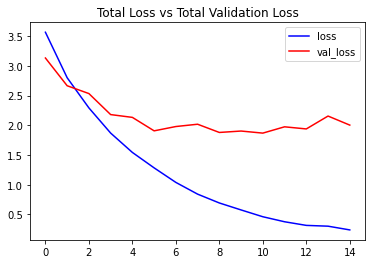

In [19]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

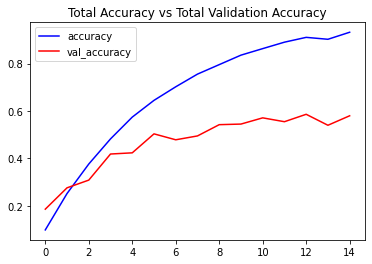

In [20]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

## LRCN Model

<center>
<img src='https://drive.google.com/uc?export=download&id=1I-q5yLsIoNh2chfzT7JYvra17FsXvdme'>
</center>

<!-- <center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center> -->

### Construct the Model

In [21]:
def create_LRCN_model():
# We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [22]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 20, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 20, 4, 4, 64)     

### Compile & Train the Model

In [24]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 40, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/40
800/800 [==============================] - 45s 53ms/step - loss: 3.8558 - accuracy: 0.0350 - val_loss: 3.6717 - val_accuracy: 0.0512
Epoch 2/40
800/800 [==============================] - 34s 43ms/step - loss: 3.5792 - accuracy: 0.0825 - val_loss: 3.6435 - val_accuracy: 0.0763
Epoch 3/40
800/800 [==============================] - 34s 43ms/step - loss: 3.3573 - accuracy: 0.1128 - val_loss: 3.3236 - val_accuracy: 0.1225
Epoch 4/40
800/800 [==============================] - 34s 43ms/step - loss: 3.1969 - accuracy: 0.1484 - val_loss: 3.1615 - val_accuracy: 0.1400
Epoch 5/40
800/800 [==============================] - 34s 43ms/step - loss: 3.0456 - accuracy: 0.1828 - val_loss: 3.0850 - val_accuracy: 0.1725
Epoch 6/40
800/800 [==============================] - 34s 43ms/step - loss: 2.9237 - accuracy: 0.2059 - val_loss: 2.8793 - val_accuracy: 0.2050
Epoch 7/40
800/800 [==============================] - 34s 43ms/step - loss: 2.8048 - accuracy: 0.2325 - val_loss: 2.9541 - val_accuracy:

### Evaluate the Model

In [25]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

32/32 [==============================] - 3s 74ms/step - loss: 1.4021 - accuracy: 0.6690


### Save the Model

In [26]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### Plot Model’s Loss & Accuracy Curves

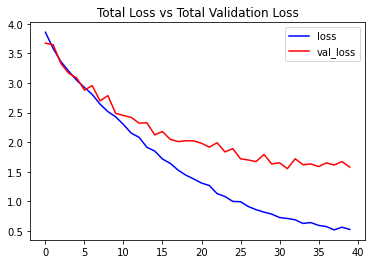

In [27]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

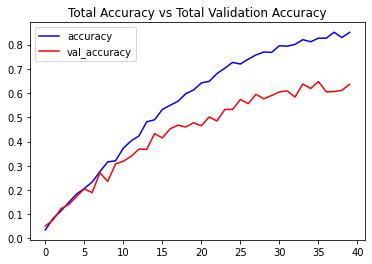

In [28]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')